In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)


In [3]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

`create Generator which uses MLP using simple dense layers activated by tanh`

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [5]:
256*100+256

25856

In [6]:
256*512+512

131584

In [7]:
512*1024+1024

525312

In [8]:
1024*784+784

803600

In [9]:
25856 + 131584 + 525312 + 803600


1486352

We now create the Discriminator which is also MLP. Discriminator will take the input from real data which is of the size 784 and also the images generated from Generator.

In [10]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
(784*1024+1024) 

803840

In [13]:
(1024*512+512) 

524800

In [14]:
 (512*256+256)

131328

In [15]:
(256*1+1)

257

In [16]:
(784*1024+1024)  + (1024 *512+512) + (512*256+256) + (256*1+1)

1460225

**
- We now create the GAN where we combine the Generator and Discriminator. 
- When we train the generator we will freeze the Discriminator.
- We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

**

In [17]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


- Before we start training the model, we will write a function plot_generated_images to plot the generated images. 
- This way we can see how the images are generated. 
- We save the generated images to file that we can view later

In [18]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

We finally start to train GAN. We will first have the full code for training GAN and then break it step by step for understanding how the training happens

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1



100%|██████████| 128/128 [00:26<00:00,  4.86it/s]

  1%|          | 1/128 [00:00<00:23,  5.47it/s]

Epoch 2



100%|██████████| 128/128 [00:24<00:00,  5.22it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 3



100%|██████████| 128/128 [00:24<00:00,  5.27it/s]

  1%|          | 1/128 [00:00<00:24,  5.21it/s]

Epoch 4



100%|██████████| 128/128 [00:24<00:00,  5.26it/s]

  1%|          | 1/128 [00:00<00:23,  5.46it/s]

Epoch 5



100%|██████████| 128/128 [00:24<00:00,  5.28it/s]

  1%|          | 1/128 [00:00<00:22,  5.53it/s]

Epoch 6



100%|██████████| 128/128 [00:24<00:00,  5.30it/s]

  0%|          | 0/128 [00:00<?, ?it/s]


Epoch 7


100%|██████████| 128/128 [00:24<00:00,  5.27it/s]

  1%|          | 1/128 [00:00<00:23,  5.45it/s]

Epoch 8



100%|██████████| 128/128 [00:24<00:00,  5.18it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 9



100%|██████████| 128/128 [00:24<00:00,  5.13it/s]

  1%|          | 1/128 [00:00<00:22,  5.63it/s]

Epoch 10



100%|██████████| 128/128 [00:24<00:00,  5.18it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 11



100%|██████████| 128/128 [00:24<00:00,  5.19it/s]

  1%|          | 1/128 [00:00<00:23,  5.31it/s]

Epoch 12



100%|██████████| 128/128 [00:24<00:00,  5.20it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 13



100%|██████████| 128/128 [00:24<00:00,  5.18it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 14



100%|██████████| 128/128 [00:24<00:00,  5.12it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 15



100%|██████████| 128/128 [00:25<00:00,  5.03it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 16



100%|██████████| 128/128 [00:25<00:00,  4.93it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 17



100%|██████████| 128/128 [00:25<00:00,  5.02it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 18



100%|██████████| 128/128 [00:25<00:00,  5.02it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 19



100%|██████████| 128/128 [00:25<00:00,  5.07it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 20



100%|██████████| 128/128 [00:25<00:00,  5.09it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 21



100%|██████████| 128/128 [00:25<00:00,  5.01it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 22



100%|██████████| 128/128 [00:25<00:00,  4.97it/s]

  1%|          | 1/128 [00:00<00:23,  5.36it/s]

Epoch 23



100%|██████████| 128/128 [00:25<00:00,  4.96it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 24



100%|██████████| 128/128 [00:25<00:00,  5.02it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 25



100%|██████████| 128/128 [00:25<00:00,  4.93it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 26



100%|██████████| 128/128 [00:25<00:00,  4.97it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 27



100%|██████████| 128/128 [00:25<00:00,  5.02it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 28



100%|██████████| 128/128 [00:24<00:00,  5.14it/s]

  1%|          | 1/128 [00:00<00:23,  5.30it/s]

Epoch 29



100%|██████████| 128/128 [00:24<00:00,  5.21it/s]

  0%|          | 0/128 [00:00<?, ?it/s]


Epoch 30


100%|██████████| 128/128 [00:24<00:00,  5.16it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 31



100%|██████████| 128/128 [00:25<00:00,  5.09it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 32



100%|██████████| 128/128 [00:25<00:00,  5.09it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 33



100%|██████████| 128/128 [00:25<00:00,  4.95it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 34



100%|██████████| 128/128 [00:25<00:00,  4.99it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 35



100%|██████████| 128/128 [00:25<00:00,  5.01it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 36



100%|██████████| 128/128 [00:25<00:00,  5.08it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 37



100%|██████████| 128/128 [00:25<00:00,  5.08it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 38



100%|██████████| 128/128 [00:25<00:00,  5.05it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 39



100%|██████████| 128/128 [00:25<00:00,  5.01it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 40



100%|██████████| 128/128 [00:25<00:00,  5.00it/s]

  1%|          | 1/128 [00:00<00:22,  5.57it/s]

Epoch 41



100%|██████████| 128/128 [00:25<00:00,  4.94it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 42



100%|██████████| 128/128 [00:25<00:00,  4.97it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 43



100%|██████████| 128/128 [00:25<00:00,  4.95it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 44



100%|██████████| 128/128 [00:26<00:00,  4.91it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 45



100%|██████████| 128/128 [00:26<00:00,  4.85it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 46



100%|██████████| 128/128 [00:25<00:00,  4.96it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 47



100%|██████████| 128/128 [00:26<00:00,  4.89it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 48



100%|██████████| 128/128 [00:25<00:00,  4.99it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 49



100%|██████████| 128/128 [00:25<00:00,  4.98it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 50



100%|██████████| 128/128 [00:25<00:00,  4.95it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 51



100%|██████████| 128/128 [00:25<00:00,  4.98it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 52



100%|██████████| 128/128 [00:25<00:00,  4.99it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 53



100%|██████████| 128/128 [00:25<00:00,  4.96it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 54



100%|██████████| 128/128 [00:25<00:00,  4.98it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 55



100%|██████████| 128/128 [00:25<00:00,  4.96it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 56



100%|██████████| 128/128 [00:25<00:00,  4.93it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 57



100%|██████████| 128/128 [00:25<00:00,  4.92it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 58



100%|██████████| 128/128 [00:26<00:00,  4.78it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 59



100%|██████████| 128/128 [00:26<00:00,  4.84it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 60



100%|██████████| 128/128 [00:26<00:00,  4.86it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 61



100%|██████████| 128/128 [00:27<00:00,  4.61it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 62



100%|██████████| 128/128 [00:26<00:00,  4.79it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 63



100%|██████████| 128/128 [00:26<00:00,  4.83it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 64



100%|██████████| 128/128 [00:26<00:00,  4.87it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 65



100%|██████████| 128/128 [00:26<00:00,  4.89it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 66



100%|██████████| 128/128 [00:26<00:00,  4.84it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 67



100%|██████████| 128/128 [00:26<00:00,  4.86it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 68



100%|██████████| 128/128 [00:26<00:00,  4.85it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 69



100%|██████████| 128/128 [00:26<00:00,  4.86it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 70



100%|██████████| 128/128 [00:26<00:00,  4.82it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 71



100%|██████████| 128/128 [00:26<00:00,  4.81it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 72



100%|██████████| 128/128 [00:26<00:00,  4.79it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 73



100%|██████████| 128/128 [00:26<00:00,  4.82it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 74



100%|██████████| 128/128 [00:26<00:00,  4.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 75



100%|██████████| 128/128 [00:26<00:00,  4.81it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 76



100%|██████████| 128/128 [00:27<00:00,  4.66it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 77



100%|██████████| 128/128 [00:26<00:00,  4.83it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 78



100%|██████████| 128/128 [00:26<00:00,  4.82it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 79



100%|██████████| 128/128 [00:26<00:00,  4.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 80



100%|██████████| 128/128 [00:26<00:00,  4.81it/s]

  1%|          | 1/128 [00:00<00:23,  5.49it/s]

Epoch 81



100%|██████████| 128/128 [00:27<00:00,  4.62it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 82



100%|██████████| 128/128 [00:26<00:00,  4.77it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 83



100%|██████████| 128/128 [00:27<00:00,  4.71it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 84



100%|██████████| 128/128 [00:26<00:00,  4.77it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 85



100%|██████████| 128/128 [00:26<00:00,  4.83it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 86



100%|██████████| 128/128 [00:26<00:00,  4.79it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 87



100%|██████████| 128/128 [00:26<00:00,  4.82it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 88



100%|██████████| 128/128 [00:26<00:00,  4.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 89



100%|██████████| 128/128 [00:26<00:00,  4.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 90



100%|██████████| 128/128 [00:26<00:00,  4.83it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 91



100%|██████████| 128/128 [00:26<00:00,  4.78it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 92



100%|██████████| 128/128 [00:26<00:00,  4.74it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 93



100%|██████████| 128/128 [00:26<00:00,  4.79it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 94



100%|██████████| 128/128 [00:27<00:00,  4.69it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 95



100%|██████████| 128/128 [00:27<00:00,  4.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 96



100%|██████████| 128/128 [00:27<00:00,  4.72it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 97



100%|██████████| 128/128 [00:27<00:00,  4.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 98



100%|██████████| 128/128 [00:27<00:00,  4.66it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 99



100%|██████████| 128/128 [00:27<00:00,  4.60it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 100



100%|██████████| 128/128 [00:27<00:00,  4.69it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 101



100%|██████████| 128/128 [00:27<00:00,  4.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 102



100%|██████████| 128/128 [00:27<00:00,  4.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 103



100%|██████████| 128/128 [00:27<00:00,  4.71it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 104



100%|██████████| 128/128 [00:27<00:00,  4.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 105



100%|██████████| 128/128 [00:27<00:00,  4.74it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 106



100%|██████████| 128/128 [00:27<00:00,  4.61it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 107



100%|██████████| 128/128 [00:28<00:00,  4.54it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 108



100%|██████████| 128/128 [00:27<00:00,  4.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 109



100%|██████████| 128/128 [00:27<00:00,  4.71it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 110



100%|██████████| 128/128 [00:27<00:00,  4.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 111



100%|██████████| 128/128 [00:27<00:00,  4.70it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 112



100%|██████████| 128/128 [00:27<00:00,  4.72it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 113



100%|██████████| 128/128 [00:27<00:00,  4.71it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 114



100%|██████████| 128/128 [00:27<00:00,  4.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 115



100%|██████████| 128/128 [00:27<00:00,  4.67it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 116



100%|██████████| 128/128 [00:27<00:00,  4.71it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 117



100%|██████████| 128/128 [00:27<00:00,  4.71it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 118



100%|██████████| 128/128 [00:27<00:00,  4.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 119



100%|██████████| 128/128 [00:27<00:00,  4.67it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 120



100%|██████████| 128/128 [00:27<00:00,  4.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 121



100%|██████████| 128/128 [00:27<00:00,  4.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 122



100%|██████████| 128/128 [00:27<00:00,  4.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 123



100%|██████████| 128/128 [00:27<00:00,  4.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 124



100%|██████████| 128/128 [00:27<00:00,  4.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 125



100%|██████████| 128/128 [00:27<00:00,  4.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 126



100%|██████████| 128/128 [00:27<00:00,  4.59it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 127



100%|██████████| 128/128 [00:27<00:00,  4.62it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 128



100%|██████████| 128/128 [00:27<00:00,  4.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 129



100%|██████████| 128/128 [00:27<00:00,  4.57it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 130



100%|██████████| 128/128 [00:27<00:00,  4.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 131



100%|██████████| 128/128 [00:27<00:00,  4.63it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 132



100%|██████████| 128/128 [00:27<00:00,  4.60it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 133



100%|██████████| 128/128 [00:27<00:00,  4.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 134



100%|██████████| 128/128 [00:27<00:00,  4.60it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 135



100%|██████████| 128/128 [00:27<00:00,  4.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 136



100%|██████████| 128/128 [00:27<00:00,  4.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 137



100%|██████████| 128/128 [00:27<00:00,  4.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 138



100%|██████████| 128/128 [00:27<00:00,  4.59it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 139



100%|██████████| 128/128 [00:28<00:00,  4.52it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 140



100%|██████████| 128/128 [00:29<00:00,  4.38it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 141



100%|██████████| 128/128 [00:28<00:00,  4.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 142



100%|██████████| 128/128 [00:27<00:00,  4.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 143



100%|██████████| 128/128 [00:27<00:00,  4.61it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 144



100%|██████████| 128/128 [00:28<00:00,  4.54it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 145



100%|██████████| 128/128 [00:28<00:00,  4.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 146



100%|██████████| 128/128 [00:28<00:00,  4.51it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 147



100%|██████████| 128/128 [00:28<00:00,  4.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 148



100%|██████████| 128/128 [00:28<00:00,  4.54it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 149



100%|██████████| 128/128 [00:28<00:00,  4.54it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 150



100%|██████████| 128/128 [00:27<00:00,  4.60it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 151



100%|██████████| 128/128 [00:28<00:00,  4.57it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 152



100%|██████████| 128/128 [00:28<00:00,  4.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 153



100%|██████████| 128/128 [00:29<00:00,  4.35it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 154



100%|██████████| 128/128 [00:27<00:00,  4.63it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 155



100%|██████████| 128/128 [00:28<00:00,  4.49it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 156



100%|██████████| 128/128 [00:28<00:00,  4.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 157



100%|██████████| 128/128 [00:28<00:00,  4.47it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 158



100%|██████████| 128/128 [00:28<00:00,  4.48it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 159



100%|██████████| 128/128 [00:28<00:00,  4.54it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 160



100%|██████████| 128/128 [00:28<00:00,  4.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 161



100%|██████████| 128/128 [00:28<00:00,  4.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 162



100%|██████████| 128/128 [00:28<00:00,  4.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 163



100%|██████████| 128/128 [00:28<00:00,  4.49it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 164



100%|██████████| 128/128 [00:28<00:00,  4.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 165



100%|██████████| 128/128 [00:28<00:00,  4.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 166



100%|██████████| 128/128 [00:28<00:00,  4.49it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 167



100%|██████████| 128/128 [00:28<00:00,  4.52it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 168



100%|██████████| 128/128 [00:29<00:00,  4.30it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 169



100%|██████████| 128/128 [00:28<00:00,  4.48it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 170



100%|██████████| 128/128 [00:29<00:00,  4.40it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 171



100%|██████████| 128/128 [00:29<00:00,  4.39it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 172



100%|██████████| 128/128 [00:28<00:00,  4.42it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 173



100%|██████████| 128/128 [00:28<00:00,  4.43it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 174



100%|██████████| 128/128 [00:29<00:00,  4.32it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 175



100%|██████████| 128/128 [00:29<00:00,  4.38it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 176



100%|██████████| 128/128 [00:29<00:00,  4.38it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 177



100%|██████████| 128/128 [00:29<00:00,  4.32it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 178



100%|██████████| 128/128 [00:29<00:00,  4.30it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 179



100%|██████████| 128/128 [00:29<00:00,  4.34it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 180



100%|██████████| 128/128 [00:29<00:00,  4.36it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 181



100%|██████████| 128/128 [00:29<00:00,  4.39it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 182



100%|██████████| 128/128 [00:29<00:00,  4.38it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 183



100%|██████████| 128/128 [00:29<00:00,  4.34it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 184



100%|██████████| 128/128 [00:29<00:00,  4.33it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 185



100%|██████████| 128/128 [00:29<00:00,  4.34it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 186



100%|██████████| 128/128 [00:30<00:00,  4.13it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 187



100%|██████████| 128/128 [00:29<00:00,  4.34it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 188



100%|██████████| 128/128 [00:29<00:00,  4.32it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 189



100%|██████████| 128/128 [00:29<00:00,  4.32it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 190



100%|██████████| 128/128 [00:29<00:00,  4.34it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 191



100%|██████████| 128/128 [00:29<00:00,  4.31it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 192



100%|██████████| 128/128 [00:29<00:00,  4.34it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 193



100%|██████████| 128/128 [00:29<00:00,  4.32it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 194



100%|██████████| 128/128 [00:30<00:00,  4.24it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 195



100%|██████████| 128/128 [00:30<00:00,  4.25it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 196



100%|██████████| 128/128 [00:29<00:00,  4.27it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 197



100%|██████████| 128/128 [00:29<00:00,  4.28it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 198



100%|██████████| 128/128 [00:29<00:00,  4.28it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 199



100%|██████████| 128/128 [00:29<00:00,  4.27it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 200



100%|██████████| 128/128 [00:29<00:00,  4.28it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 201



100%|██████████| 128/128 [00:29<00:00,  4.30it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 202



100%|██████████| 128/128 [00:29<00:00,  4.30it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 203



100%|██████████| 128/128 [00:29<00:00,  4.28it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 204



100%|██████████| 128/128 [00:29<00:00,  4.30it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 205



100%|██████████| 128/128 [00:29<00:00,  4.28it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 206



100%|██████████| 128/128 [00:31<00:00,  4.04it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 207



100%|██████████| 128/128 [00:30<00:00,  4.25it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 208



100%|██████████| 128/128 [00:30<00:00,  4.21it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 209



100%|██████████| 128/128 [00:30<00:00,  4.21it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 210



100%|██████████| 128/128 [00:30<00:00,  4.25it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 211



100%|██████████| 128/128 [00:30<00:00,  4.21it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 212



100%|██████████| 128/128 [00:30<00:00,  4.26it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 213



100%|██████████| 128/128 [00:30<00:00,  4.21it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 214



100%|██████████| 128/128 [00:30<00:00,  4.21it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 215



100%|██████████| 128/128 [00:30<00:00,  4.17it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 216



100%|██████████| 128/128 [00:30<00:00,  4.22it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 217



100%|██████████| 128/128 [00:30<00:00,  4.14it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 218



100%|██████████| 128/128 [00:30<00:00,  4.21it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 219



100%|██████████| 128/128 [00:30<00:00,  4.21it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 220



100%|██████████| 128/128 [00:30<00:00,  4.13it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 221



100%|██████████| 128/128 [00:30<00:00,  4.22it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 222



100%|██████████| 128/128 [00:30<00:00,  4.14it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 223



100%|██████████| 128/128 [00:30<00:00,  4.15it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 224



100%|██████████| 128/128 [00:30<00:00,  4.14it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 225



100%|██████████| 128/128 [00:30<00:00,  4.16it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 226



100%|██████████| 128/128 [00:31<00:00,  4.11it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 227



100%|██████████| 128/128 [00:30<00:00,  4.16it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 228



100%|██████████| 128/128 [00:32<00:00,  3.94it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 229



100%|██████████| 128/128 [00:30<00:00,  4.14it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 230



100%|██████████| 128/128 [00:31<00:00,  4.07it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 231



100%|██████████| 128/128 [00:31<00:00,  4.13it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 232



100%|██████████| 128/128 [00:31<00:00,  4.13it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 233



100%|██████████| 128/128 [00:31<00:00,  4.12it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 234



100%|██████████| 128/128 [00:31<00:00,  4.07it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 235



100%|██████████| 128/128 [00:31<00:00,  4.11it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 236



100%|██████████| 128/128 [00:31<00:00,  4.08it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 237



100%|██████████| 128/128 [00:31<00:00,  4.02it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 238



100%|██████████| 128/128 [00:31<00:00,  4.09it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 239



100%|██████████| 128/128 [00:31<00:00,  4.08it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 240



100%|██████████| 128/128 [00:31<00:00,  4.09it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 241



100%|██████████| 128/128 [00:31<00:00,  4.08it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 242



100%|██████████| 128/128 [00:31<00:00,  4.07it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 243



100%|██████████| 128/128 [00:31<00:00,  4.05it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 244



100%|██████████| 128/128 [00:31<00:00,  4.02it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 245



100%|██████████| 128/128 [00:32<00:00,  4.00it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 246



100%|██████████| 128/128 [00:31<00:00,  4.01it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 247



100%|██████████| 128/128 [00:32<00:00,  3.98it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 248



100%|██████████| 128/128 [00:31<00:00,  4.05it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 249



100%|██████████| 128/128 [00:31<00:00,  4.03it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 250



100%|██████████| 128/128 [00:31<00:00,  4.02it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 251



100%|██████████| 128/128 [00:31<00:00,  4.03it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 252



100%|██████████| 128/128 [00:31<00:00,  4.03it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 253



100%|██████████| 128/128 [00:33<00:00,  3.78it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 254



100%|██████████| 128/128 [00:32<00:00,  4.00it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 255



100%|██████████| 128/128 [00:32<00:00,  3.97it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 256



100%|██████████| 128/128 [00:31<00:00,  4.03it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 257



100%|██████████| 128/128 [00:32<00:00,  3.95it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 258



100%|██████████| 128/128 [00:32<00:00,  4.00it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 259



100%|██████████| 128/128 [00:31<00:00,  4.05it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 260



100%|██████████| 128/128 [00:32<00:00,  3.97it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 261



100%|██████████| 128/128 [00:32<00:00,  3.99it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 262



100%|██████████| 128/128 [00:31<00:00,  4.02it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 263



100%|██████████| 128/128 [00:32<00:00,  3.95it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 264



100%|██████████| 128/128 [00:32<00:00,  3.94it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 265



100%|██████████| 128/128 [00:31<00:00,  4.00it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 266



100%|██████████| 128/128 [00:32<00:00,  3.89it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 267



100%|██████████| 128/128 [00:32<00:00,  3.93it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 268



100%|██████████| 128/128 [00:32<00:00,  3.89it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 269



100%|██████████| 128/128 [00:32<00:00,  3.92it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 270



100%|██████████| 128/128 [00:32<00:00,  3.89it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 271



100%|██████████| 128/128 [00:32<00:00,  3.95it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 272



100%|██████████| 128/128 [00:33<00:00,  3.86it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 273



100%|██████████| 128/128 [00:32<00:00,  3.93it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 274



100%|██████████| 128/128 [00:33<00:00,  3.88it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 275



100%|██████████| 128/128 [00:33<00:00,  3.86it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 276



100%|██████████| 128/128 [00:32<00:00,  3.93it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 277



100%|██████████| 128/128 [00:33<00:00,  3.84it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 278



100%|██████████| 128/128 [00:32<00:00,  3.91it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 279



100%|██████████| 128/128 [00:32<00:00,  3.92it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 280



100%|██████████| 128/128 [00:34<00:00,  3.69it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 281



100%|██████████| 128/128 [00:32<00:00,  3.93it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 282



100%|██████████| 128/128 [00:32<00:00,  3.88it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 283



100%|██████████| 128/128 [00:32<00:00,  3.91it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 284



100%|██████████| 128/128 [00:33<00:00,  3.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 285



100%|██████████| 128/128 [00:32<00:00,  3.89it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 286



100%|██████████| 128/128 [00:33<00:00,  3.87it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 287



100%|██████████| 128/128 [00:32<00:00,  3.89it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 288



100%|██████████| 128/128 [00:32<00:00,  3.88it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 289



100%|██████████| 128/128 [00:33<00:00,  3.78it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 290



100%|██████████| 128/128 [00:33<00:00,  3.86it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 291



100%|██████████| 128/128 [00:33<00:00,  3.85it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 292



100%|██████████| 128/128 [00:33<00:00,  3.83it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 293



100%|██████████| 128/128 [00:33<00:00,  3.85it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 294



100%|██████████| 128/128 [00:33<00:00,  3.84it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 295



100%|██████████| 128/128 [00:33<00:00,  3.81it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 296



100%|██████████| 128/128 [00:34<00:00,  3.73it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 297



100%|██████████| 128/128 [00:33<00:00,  3.82it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 298



100%|██████████| 128/128 [00:33<00:00,  3.82it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 299



100%|██████████| 128/128 [00:33<00:00,  3.81it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 300



100%|██████████| 128/128 [00:33<00:00,  3.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 301



100%|██████████| 128/128 [00:33<00:00,  3.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 302



100%|██████████| 128/128 [00:33<00:00,  3.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 303



100%|██████████| 128/128 [00:33<00:00,  3.77it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 304



100%|██████████| 128/128 [00:33<00:00,  3.77it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 305



100%|██████████| 128/128 [00:33<00:00,  3.77it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 306



100%|██████████| 128/128 [00:34<00:00,  3.75it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 307



100%|██████████| 128/128 [00:34<00:00,  3.74it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 308



100%|██████████| 128/128 [00:34<00:00,  3.74it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 309



100%|██████████| 128/128 [00:34<00:00,  3.74it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 310



100%|██████████| 128/128 [00:34<00:00,  3.74it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 311



100%|██████████| 128/128 [00:34<00:00,  3.74it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 312



100%|██████████| 128/128 [00:34<00:00,  3.76it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 313



100%|██████████| 128/128 [00:34<00:00,  3.73it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 314



100%|██████████| 128/128 [00:34<00:00,  3.70it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 315



100%|██████████| 128/128 [00:33<00:00,  3.82it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 316



100%|██████████| 128/128 [00:34<00:00,  3.71it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 317



100%|██████████| 128/128 [00:34<00:00,  3.70it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 318



100%|██████████| 128/128 [00:34<00:00,  3.71it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 319



100%|██████████| 128/128 [00:34<00:00,  3.69it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 320



100%|██████████| 128/128 [00:34<00:00,  3.70it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 321



100%|██████████| 128/128 [00:34<00:00,  3.72it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 322



100%|██████████| 128/128 [00:33<00:00,  3.80it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 323



100%|██████████| 128/128 [00:35<00:00,  3.63it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 324



100%|██████████| 128/128 [00:35<00:00,  3.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 325



100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 326



100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 327



100%|██████████| 128/128 [00:34<00:00,  3.74it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 328



100%|██████████| 128/128 [00:35<00:00,  3.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 329



100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 330



100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 331



100%|██████████| 128/128 [00:35<00:00,  3.61it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 332



100%|██████████| 128/128 [00:34<00:00,  3.72it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 333



100%|██████████| 128/128 [00:35<00:00,  3.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 334



100%|██████████| 128/128 [00:35<00:00,  3.60it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 335



100%|██████████| 128/128 [00:37<00:00,  3.37it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 336



100%|██████████| 128/128 [00:34<00:00,  3.72it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 337



100%|██████████| 128/128 [00:35<00:00,  3.60it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 338



100%|██████████| 128/128 [00:35<00:00,  3.62it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 339



100%|██████████| 128/128 [00:35<00:00,  3.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 340



100%|██████████| 128/128 [00:34<00:00,  3.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 341



100%|██████████| 128/128 [00:34<00:00,  3.73it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 342



100%|██████████| 128/128 [00:35<00:00,  3.60it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 343



100%|██████████| 128/128 [00:35<00:00,  3.59it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 344



100%|██████████| 128/128 [00:34<00:00,  3.68it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 345



100%|██████████| 128/128 [00:35<00:00,  3.57it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 346



100%|██████████| 128/128 [00:35<00:00,  3.57it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 347



100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 348



100%|██████████| 128/128 [00:35<00:00,  3.62it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 349



100%|██████████| 128/128 [00:35<00:00,  3.57it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 350



100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 351



100%|██████████| 128/128 [00:35<00:00,  3.57it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 352



100%|██████████| 128/128 [00:36<00:00,  3.55it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 353



100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 354



100%|██████████| 128/128 [00:36<00:00,  3.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 355



100%|██████████| 128/128 [00:36<00:00,  3.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 356



100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 357



100%|██████████| 128/128 [00:36<00:00,  3.52it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 358



100%|██████████| 128/128 [00:35<00:00,  3.64it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 359



100%|██████████| 128/128 [00:36<00:00,  3.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 360



100%|██████████| 128/128 [00:37<00:00,  3.45it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 361



100%|██████████| 128/128 [00:38<00:00,  3.35it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 362



100%|██████████| 128/128 [00:37<00:00,  3.46it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 363



100%|██████████| 128/128 [00:35<00:00,  3.61it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 364



100%|██████████| 128/128 [00:37<00:00,  3.45it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 365



100%|██████████| 128/128 [00:35<00:00,  3.57it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 366



100%|██████████| 128/128 [00:36<00:00,  3.52it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 367



100%|██████████| 128/128 [00:36<00:00,  3.47it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 368



100%|██████████| 128/128 [00:35<00:00,  3.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 369



100%|██████████| 128/128 [00:37<00:00,  3.45it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 370



100%|██████████| 128/128 [00:35<00:00,  3.63it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 371



100%|██████████| 128/128 [00:36<00:00,  3.47it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 372



100%|██████████| 128/128 [00:35<00:00,  3.61it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 373



100%|██████████| 128/128 [00:36<00:00,  3.47it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 374



100%|██████████| 128/128 [00:35<00:00,  3.59it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 375



100%|██████████| 128/128 [00:36<00:00,  3.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 376



100%|██████████| 128/128 [00:35<00:00,  3.57it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 377



100%|██████████| 128/128 [00:36<00:00,  3.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 378



100%|██████████| 128/128 [00:36<00:00,  3.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 379



100%|██████████| 128/128 [00:35<00:00,  3.59it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 380



100%|██████████| 128/128 [00:37<00:00,  3.43it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 381



100%|██████████| 128/128 [00:35<00:00,  3.60it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 382



100%|██████████| 128/128 [00:37<00:00,  3.42it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 383



100%|██████████| 128/128 [00:35<00:00,  3.58it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 384



100%|██████████| 128/128 [00:37<00:00,  3.42it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 385



100%|██████████| 128/128 [00:36<00:00,  3.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 386



100%|██████████| 128/128 [00:37<00:00,  3.41it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 387



100%|██████████| 128/128 [00:36<00:00,  3.53it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 388



100%|██████████| 128/128 [00:36<00:00,  3.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 389



100%|██████████| 128/128 [00:37<00:00,  3.40it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 390



100%|██████████| 128/128 [00:36<00:00,  3.52it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 391



100%|██████████| 128/128 [00:38<00:00,  3.36it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 392



100%|██████████| 128/128 [00:36<00:00,  3.52it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 393



100%|██████████| 128/128 [00:36<00:00,  3.52it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 394



100%|██████████| 128/128 [00:38<00:00,  3.33it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 395



100%|██████████| 128/128 [00:36<00:00,  3.52it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 396



100%|██████████| 128/128 [00:38<00:00,  3.35it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 397



100%|██████████| 128/128 [00:36<00:00,  3.48it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 398



100%|██████████| 128/128 [00:36<00:00,  3.50it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 399



100%|██████████| 128/128 [00:38<00:00,  3.34it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 400



100%|██████████| 128/128 [00:36<00:00,  3.49it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


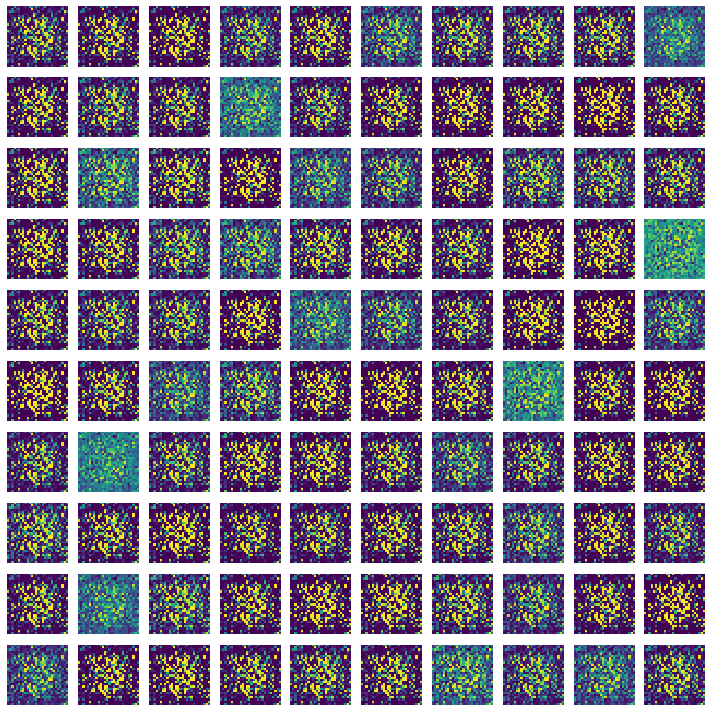

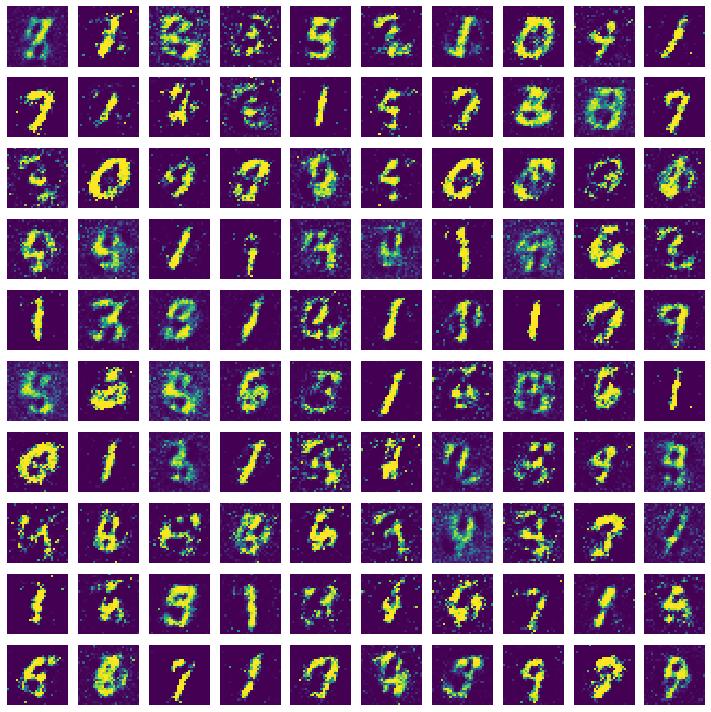

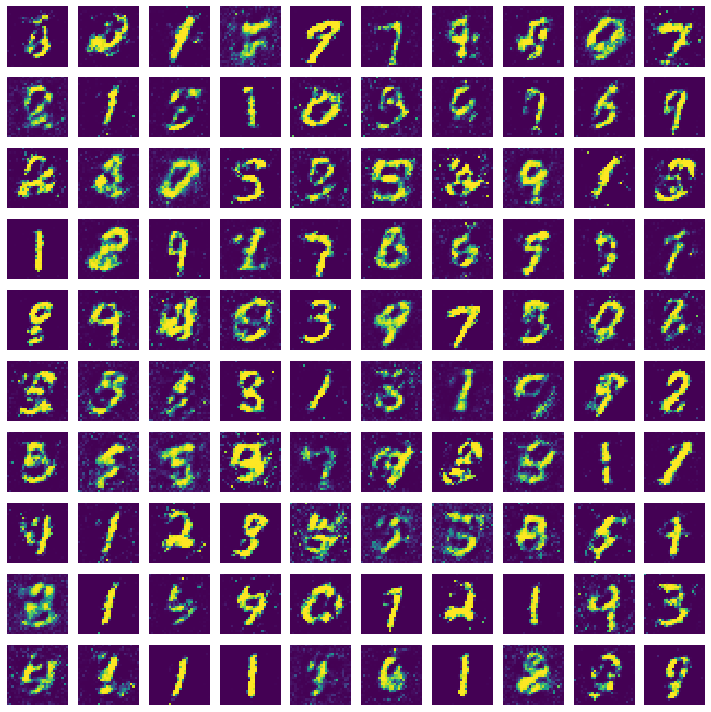

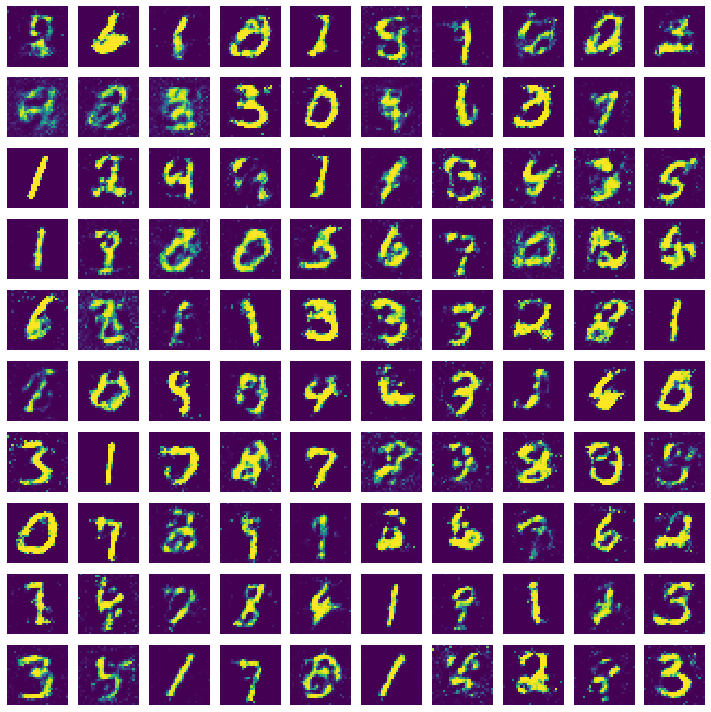

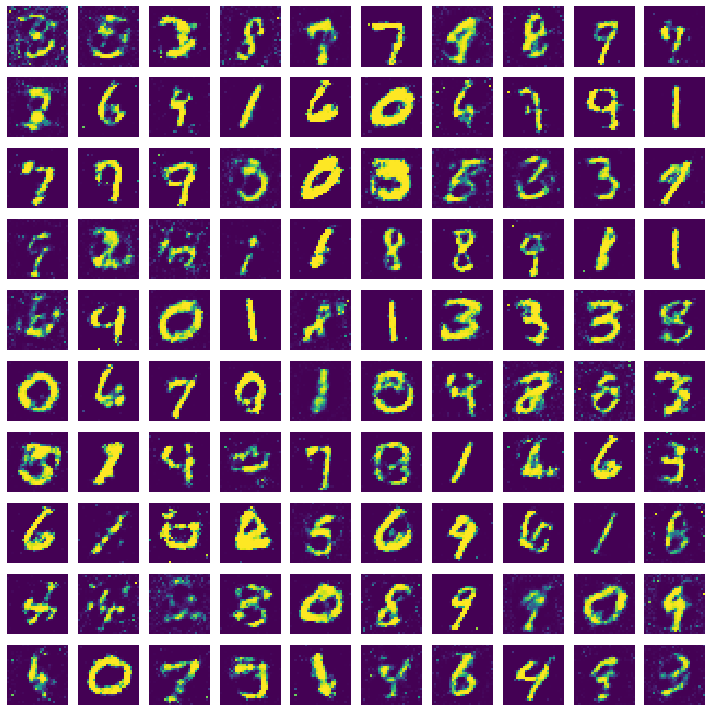

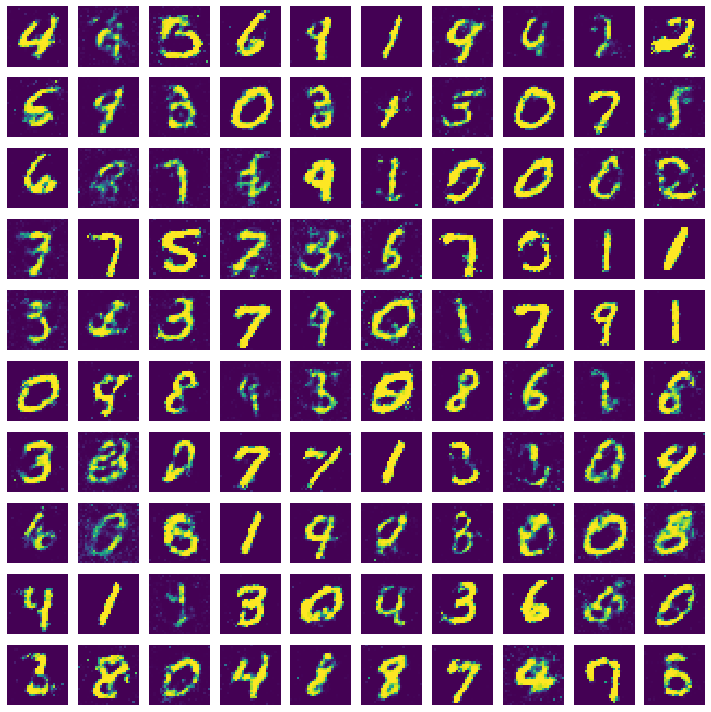

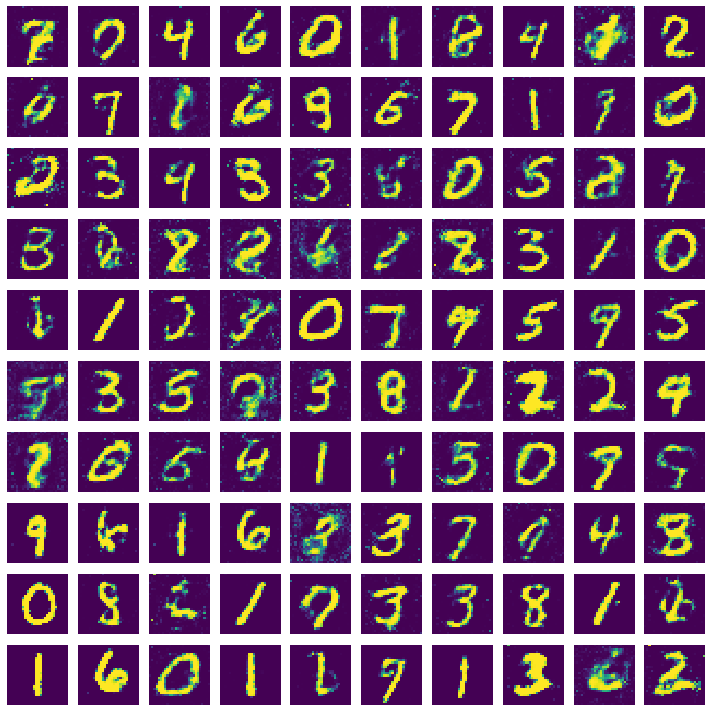

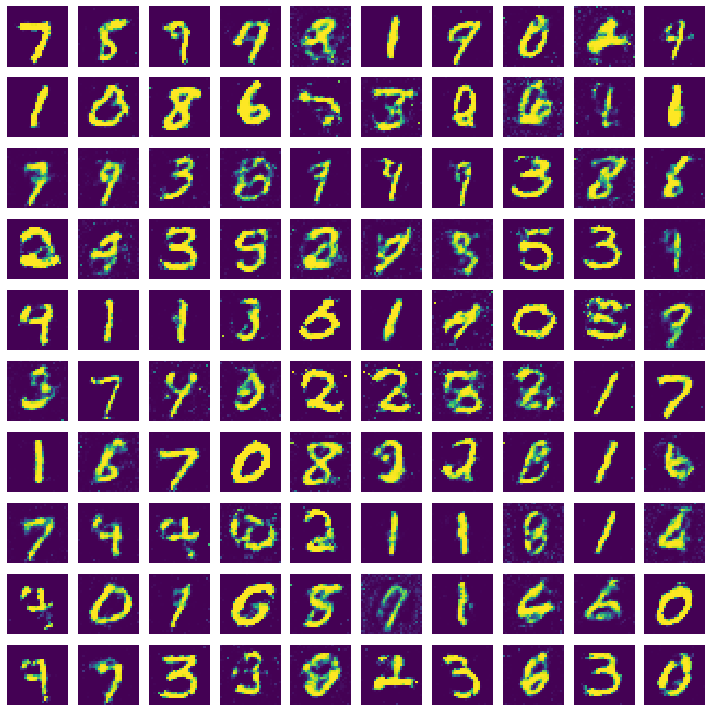

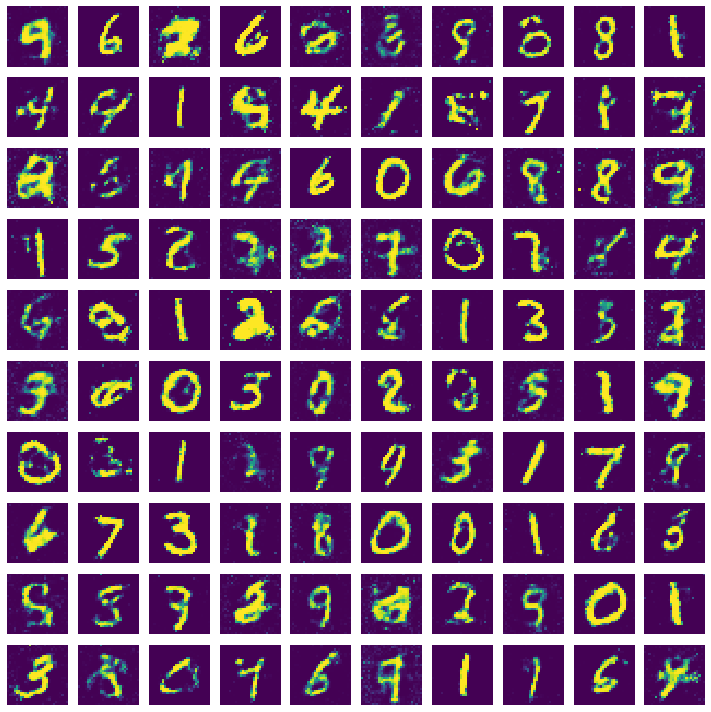

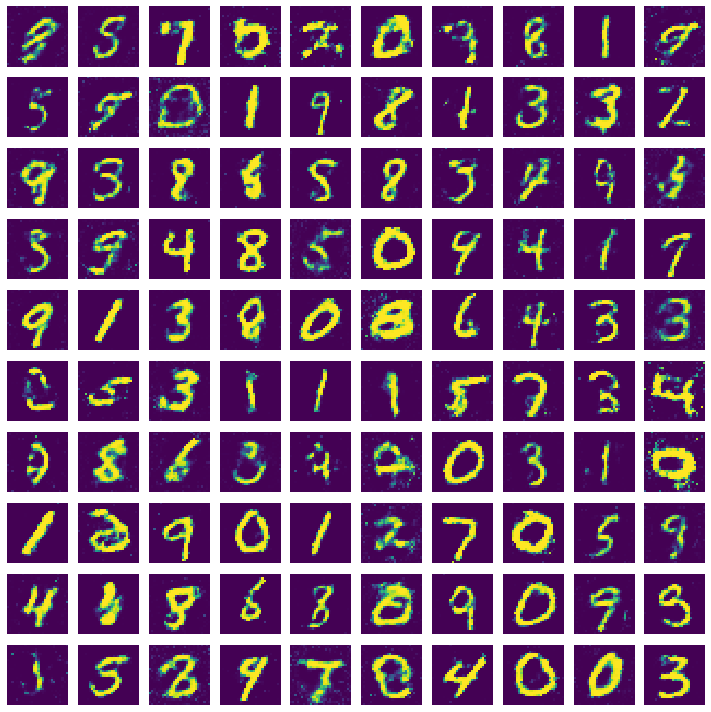

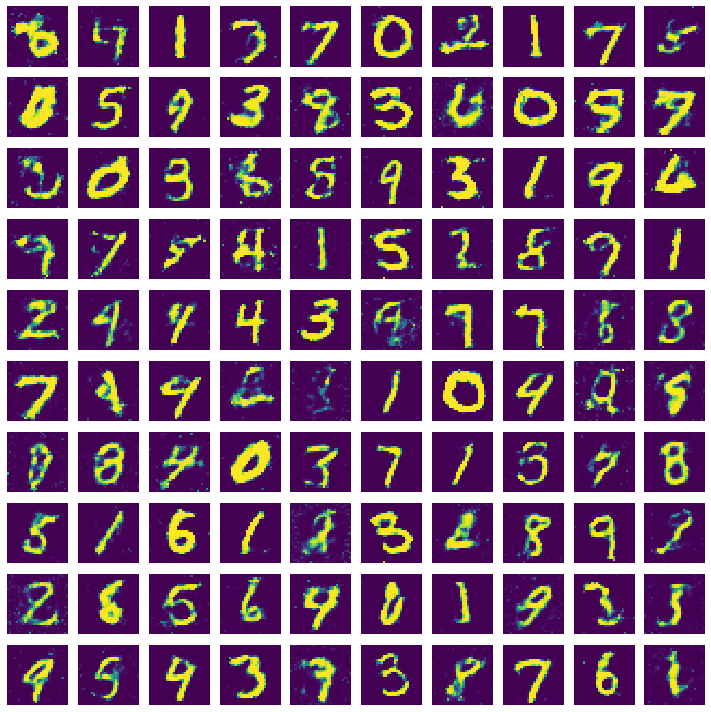

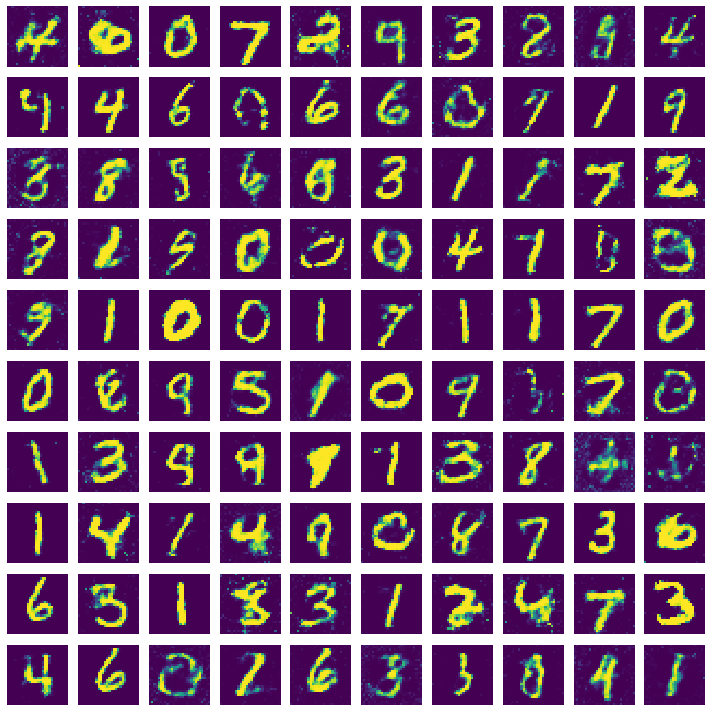

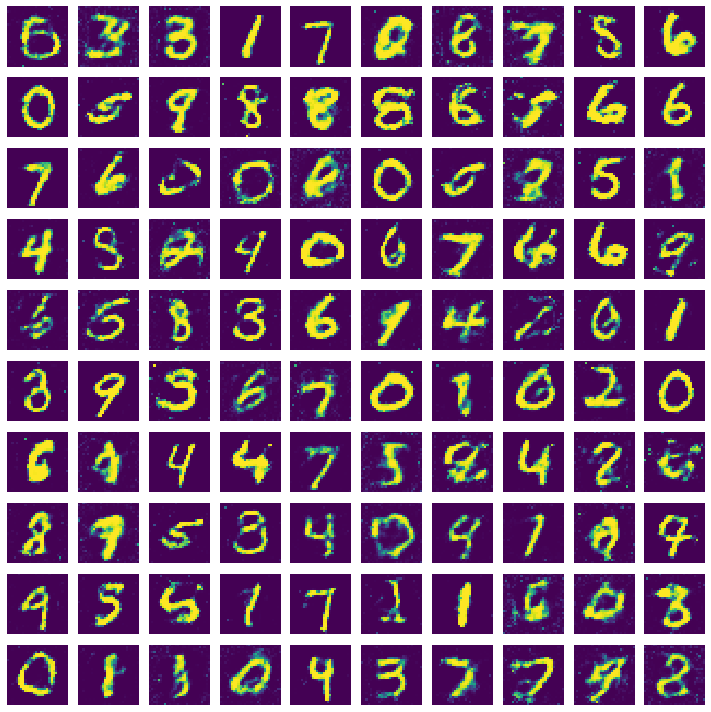

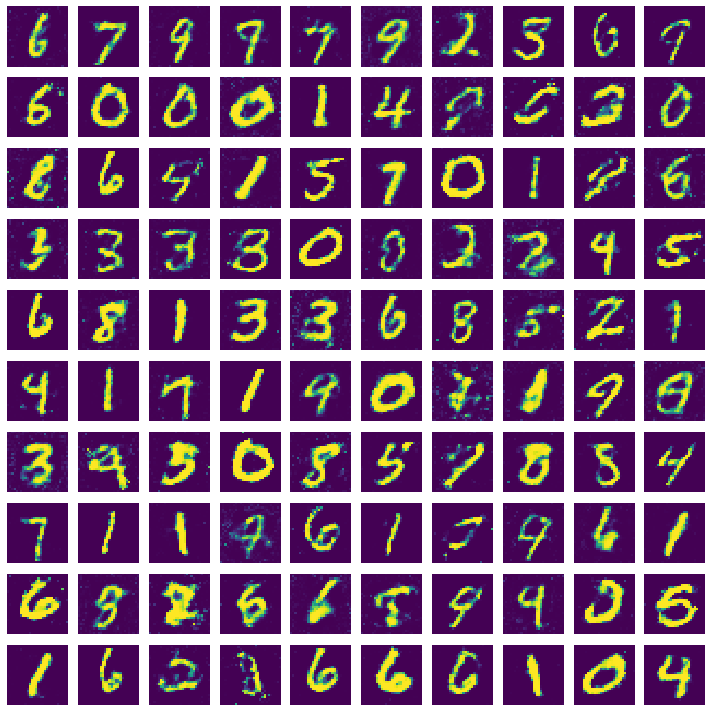

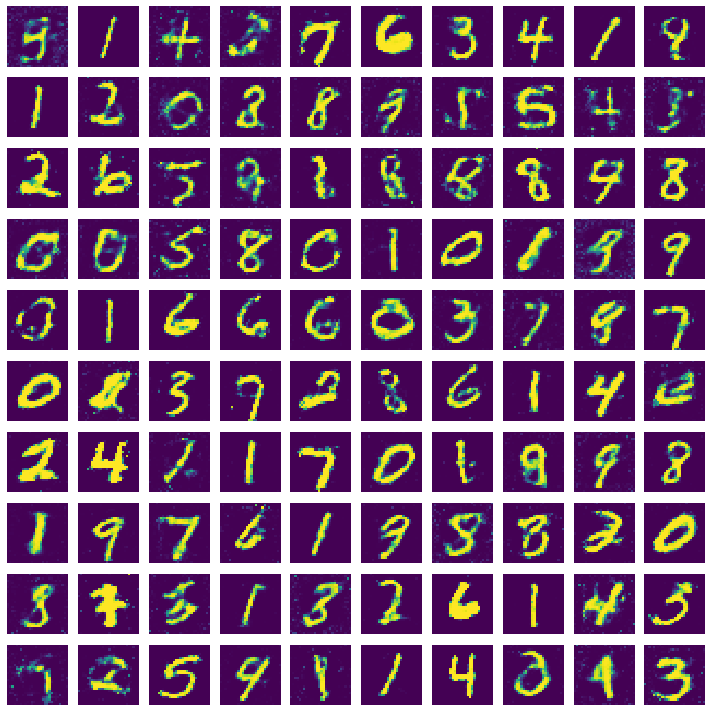

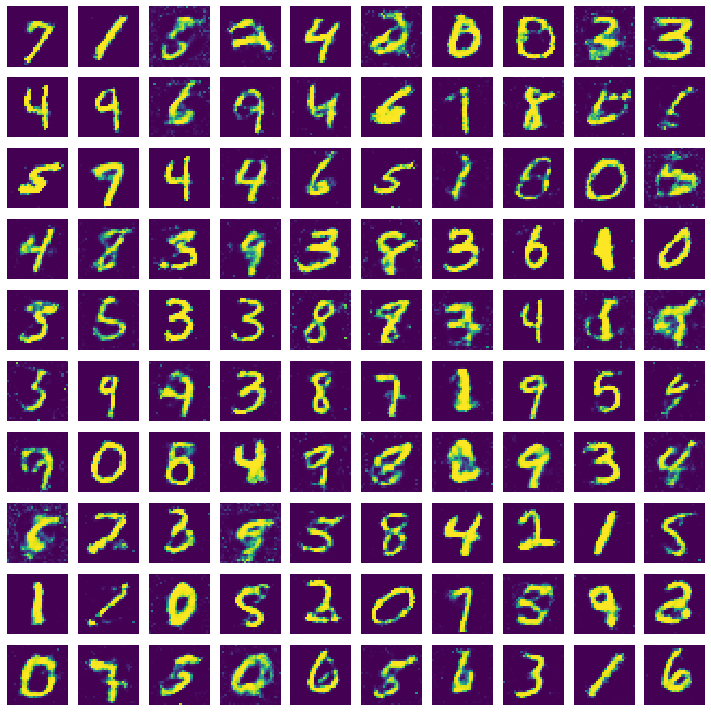

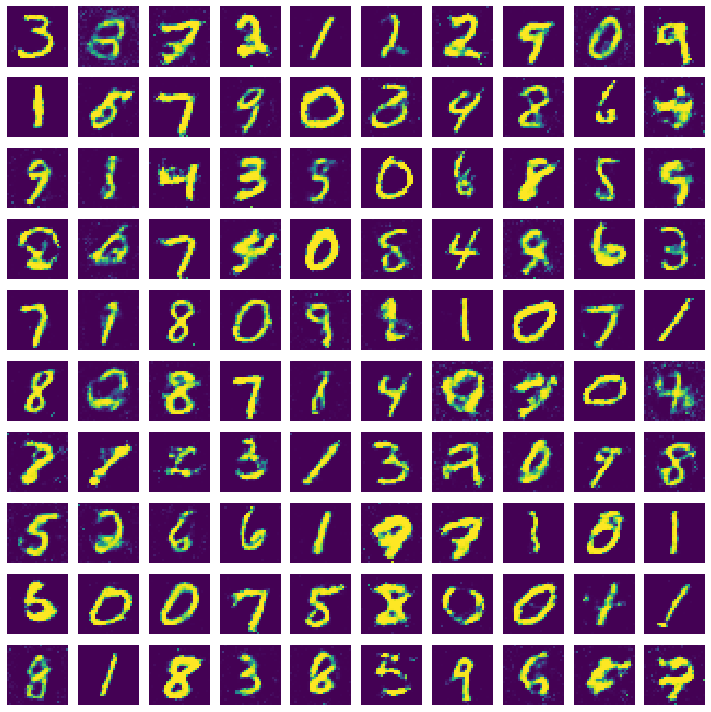

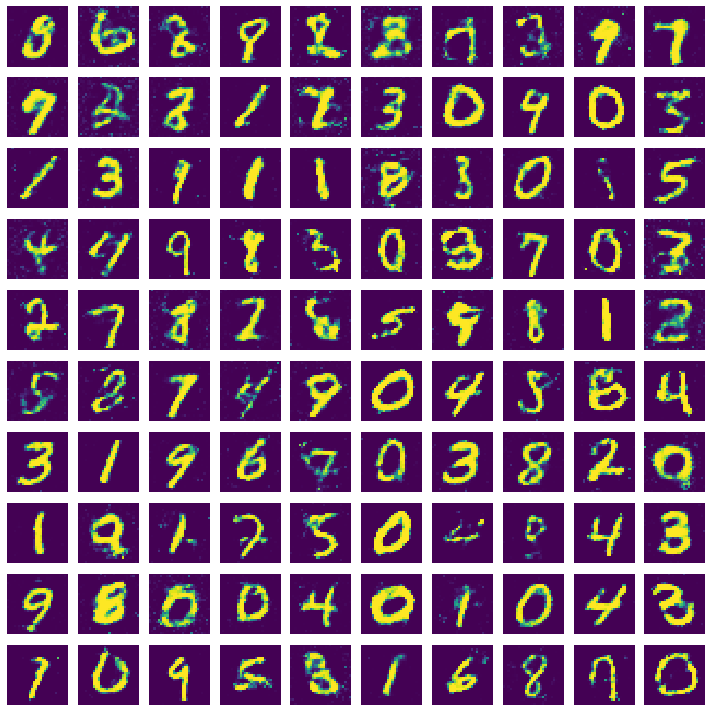

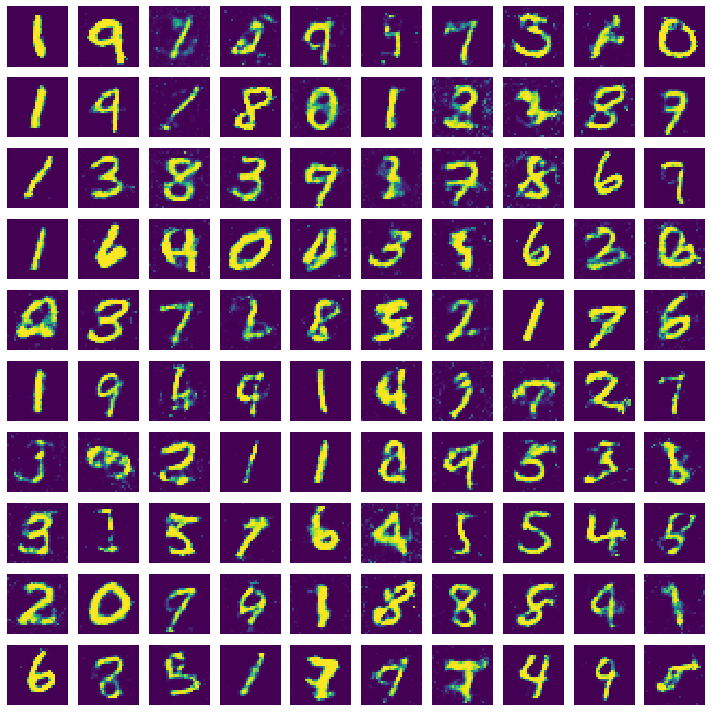

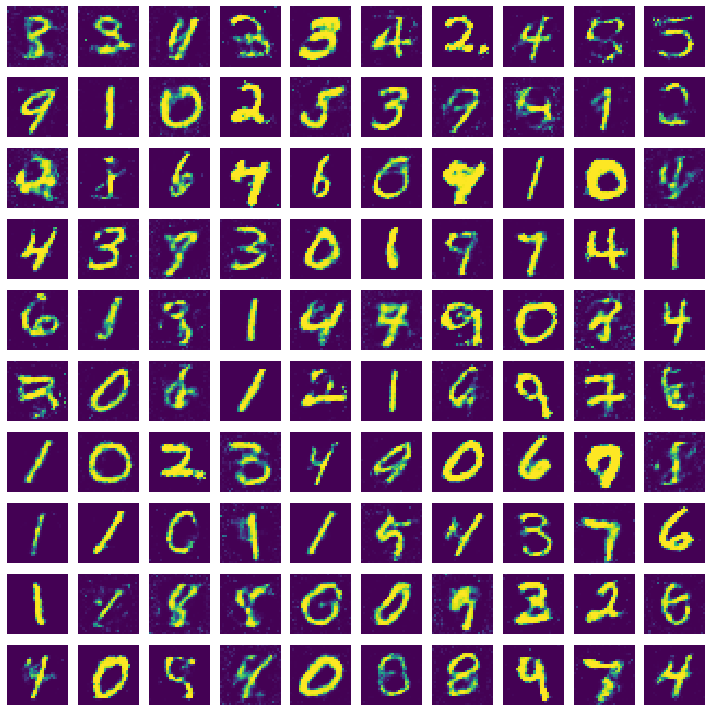

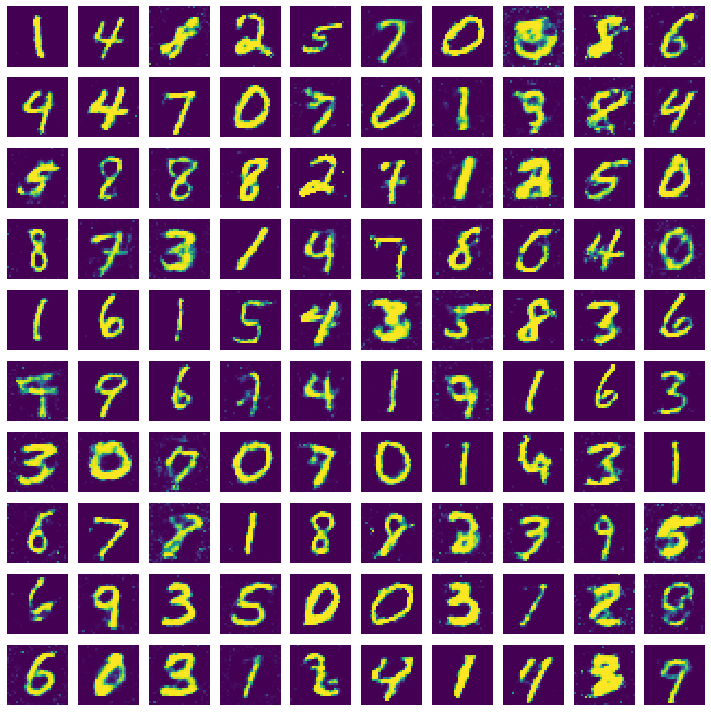

In [20]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    

    #For each epoch, we use tqdm to make our loops show a smart progress meter. We create random noise to initialize the generator.
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            #We need to create batches of data that contain fake images from Generator and real images from the MNIST dataset that we will feed to Discriminator

            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            #We create a target variable for the real and fake images.
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #We now pre-train the Discriminator on some fake and real data before starting the GAN. 
            #This helps to check if our compiled models run fine on our real data as well as the noised data.
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)


        #For every 20 epochs, we plot the generated images    
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(400,128)
plt.show()

'''
1.Why are we changing the level to 1 for fake data only while training GAN ?
2. Why only fake data is eing used totrain the generator part of GAN ?
 

Response :
1. We aren't training whole GAN on these Fake labels(1 for false), we update the weights of GAN using these, and 
discriminator weights remain unchanged during this, 
This is like training generator with a objective that discriminator should Completely fail in its predictions, 
but we can't directly train discriminator for this so we train Generator to achieve this objective.
2. Generator's work is to make random data look as real as possible, so it isn't required to train on real data for this,just fake data is sufficient.

'''

